In [15]:
!pip install pyannote.audio librosa soundfile scipy matplotlib

In [16]:
!pip show pyannote.audio

Name: pyannote.audio
Version: 3.3.2
Summary: Neural building blocks for speaker diarization
Home-page: https://github.com/pyannote/pyannote-audio
Author: Hervé Bredin
Author-email: herve.bredin@irit.fr
License: mit
Location: C:\Users\aksha\anaconda3\Lib\site-packages
Requires: asteroid-filterbanks, einops, huggingface-hub, lightning, omegaconf, pyannote.core, pyannote.database, pyannote.metrics, pyannote.pipeline, pytorch-metric-learning, rich, semver, soundfile, speechbrain, tensorboardX, torch, torch-audiomentations, torchaudio, torchmetrics
Required-by: 


In [17]:
!pip install librosa

Noise reduction using FFT complete! Filtered audio saved as Filtered_Audio.wav.


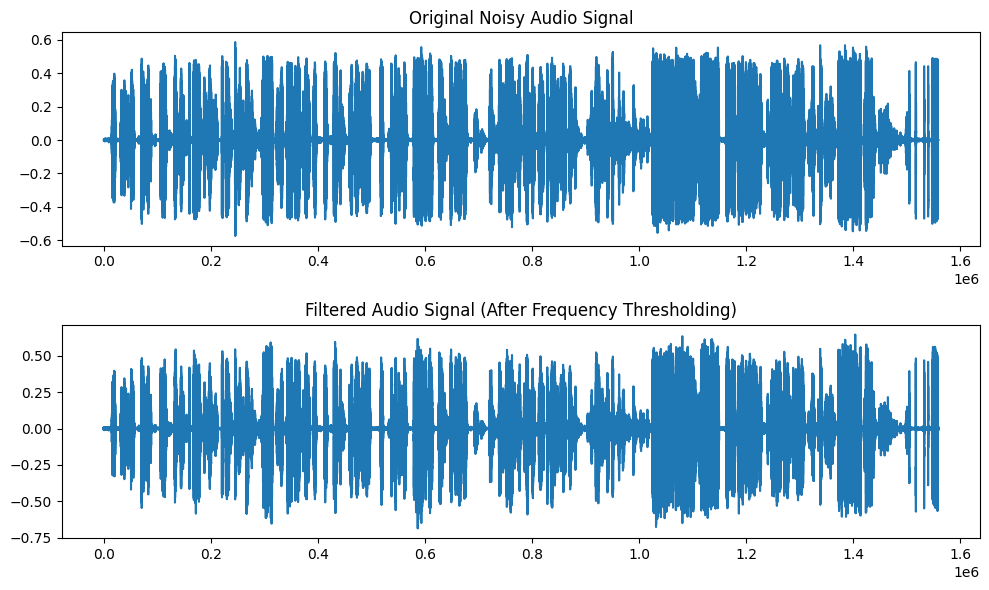

In [17]:
## Method 1:- Simple Band-Pass Filter

!pip install librosa
!pip install soundfile
!pip install scipy

import numpy as np
import librosa
import soundfile as sf
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

# Step 1: Provide the file path of the noisy audio
audio_path = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"  # Replace this with your actual file path

# Step 2: Load the noisy audio file using librosa
noisy_audio, sr = librosa.load(audio_path, sr=None)  # sr=None preserves the original sample rate

# Step 3: Perform FFT on the noisy audio signal
fft_audio = fft(noisy_audio)

# Step 4: Frequency thresholding (remove frequencies above 3 kHz)
# Get the frequency bins corresponding to the FFT results
frequencies = np.fft.fftfreq(len(fft_audio), 1/sr)

# Apply a threshold to remove noise above 3 kHz
threshold1 = 3000  # 3 kHz
threshold2 = 250
fft_audio[np.abs(frequencies) > threshold1] = 0
fft_audio[np.abs(frequencies) < threshold2] = 0

# Step 5: Apply inverse FFT to get the filtered audio signal
filtered_audio = np.real(ifft(fft_audio))

# Step 6: Save the filtered audio to a file
output_filename = 'Filtered_Audio.wav'
sf.write(output_filename, filtered_audio, sr)

print(f"Noise reduction using FFT complete! Filtered audio saved as {output_filename}.")

# Optional: Plot the original and filtered signals for visualization
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(noisy_audio)
plt.title('Original Noisy Audio Signal')
plt.subplot(2, 1, 2)
plt.plot(filtered_audio)
plt.title('Filtered Audio Signal (After Frequency Thresholding)')
plt.tight_layout()
plt.show()

In [16]:
## Method 2:- Pitch based Filtering

import librosa
import numpy as np
import soundfile as sf
from scipy.signal import butter, lfilter

# Step 1: Load the audio file
audio_path = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
audio, sr = librosa.load(audio_path, sr=None)

# Step 2: Perform pitch tracking
f0, voiced_flag, _ = librosa.pyin(audio, fmin=75, fmax=600, sr=sr, frame_length=2048, hop_length=256)

# Filter to retain only the voiced portions based on pitch tracking
pitch_filtered_audio = np.zeros_like(audio)
for i, voiced in enumerate(voiced_flag):
    if voiced:  # Retain frames with detected pitch only
        frame_start = i * 256
        frame_end = frame_start + 2048
        pitch_filtered_audio[frame_start:frame_end] = audio[frame_start:frame_end]

# Step 3: Define bandpass filter for harmonic filtering
def butter_bandpass(lowcut, highcut, sr, order=5):
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, sr, order=5):
    b, a = butter_bandpass(lowcut, highcut, sr, order=order)
    return lfilter(b, a, data)

# Step 4: Apply bandpass filter within the pitch range
# Harmonic filter based on typical human voice range (adjust range if needed)
lowcut, highcut = 75, 3000  # Hz range based on pitch detection limits
harmonic_filtered_audio = apply_bandpass_filter(pitch_filtered_audio, lowcut, highcut, sr)

# Step 5: Amplify the filtered audio by 3X
harmonic_filtered_audio *= 3

# Step 6: Save the amplified filtered audio
output_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\filtered_pitch_harmonics_audio.wav"
sf.write(output_file, harmonic_filtered_audio, sr)

print(f"Filtered and amplified audio saved to: {output_file}")


Filtered and amplified audio saved to: C:\Users\aksha\Deep Learning Labs\MHA Project\filtered_pitch_harmonics_audio.wav


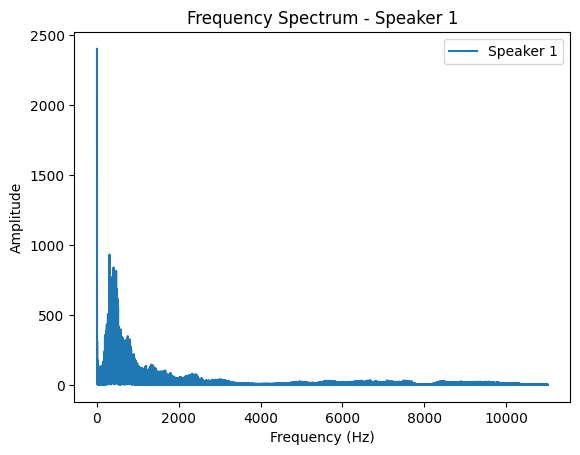

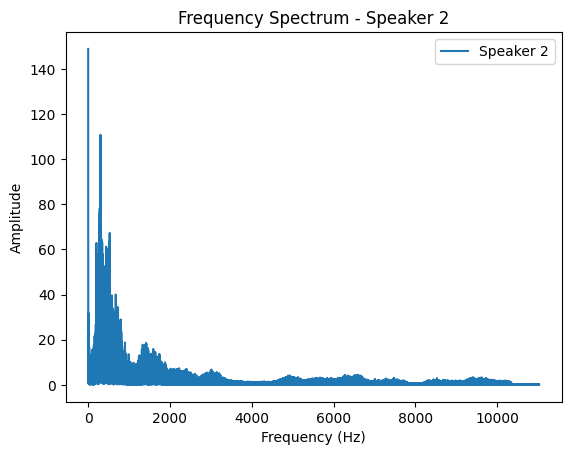

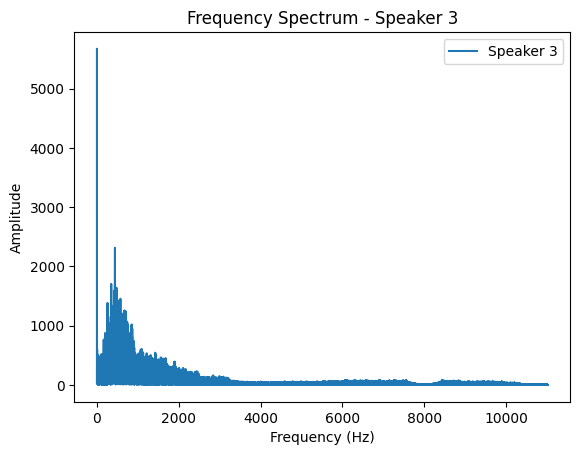

Dominant frequencies for each speaker:
Speaker 1: [410.89360955 367.51612974 307.40980513 417.2878994  406.71139835
 469.23718399 405.63992275 317.2950316  307.51349631   0.        ]
Speaker 2: [282.45664675 278.72135788 280.53985378 291.54912625 284.76662803
 287.46979761 288.84595667 281.0804877  299.90437767   0.        ]
Speaker 3: [439.9125966  440.9402115  441.22047011 441.12705057 440.37969428
 440.42640405 440.80008219 440.23956497 440.51982358   0.        ]

Bandpass Filter Applied with range: 20 Hz to 2969.237183988764 Hz
Amplified filtered audio saved to C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_10_filtered.wav


In [22]:
## Method 3:- Frequency based Filtering

##Single Audio file only

import librosa
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import soundfile as sf  # Import for saving audio files

# Load audio and extract MFCC features
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def extract_features(audio, sr, hop_length=512):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=hop_length)
    return mfcc.T

# Perform speaker diarization using KMeans clustering
def speaker_diarization(mfcc_features, num_speakers=2):
    kmeans = KMeans(n_clusters=num_speakers, random_state=0)
    speaker_labels = kmeans.fit_predict(mfcc_features)
    return speaker_labels

# Identify the frequency range in an audio segment using FFT
def identify_frequency_range(audio_segment, sr):
    fft_vals = np.fft.rfft(audio_segment)
    freqs = np.fft.rfftfreq(len(audio_segment), 1 / sr)
    return freqs, np.abs(fft_vals)

# Bandpass filter function
def bandpass_filter(audio, sr, lowcut, highcut, order=5):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=sr, output='sos')
    filtered_audio = sosfilt(sos, audio)
    return filtered_audio

# Main function for speaker diarization and frequency analysis
def process_audio(input_file, num_speakers=2, hop_length=512):
    audio, sr = load_audio(input_file)
    mfcc_features = extract_features(audio, sr, hop_length=hop_length)
    
    # Perform Speaker Diarization
    speaker_labels = speaker_diarization(mfcc_features, num_speakers=num_speakers)
    
    frame_size = hop_length
    num_frames = len(speaker_labels)
    speaker_frequencies = {}

    # Identify frequency ranges for each speaker
    for speaker in range(num_speakers):
        speaker_frames = [audio[i * frame_size: (i + 1) * frame_size]
                          for i in range(num_frames) if speaker_labels[i] == speaker]
        speaker_segment = np.concatenate(speaker_frames) if speaker_frames else np.array([])

        if speaker_segment.size > 0:
            freqs, fft_vals = identify_frequency_range(speaker_segment, sr)
            dominant_freqs = freqs[np.argsort(fft_vals)[-10:]]
            speaker_frequencies[speaker] = dominant_freqs
            
            plt.plot(freqs, fft_vals, label=f'Speaker {speaker + 1}')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.title(f'Frequency Spectrum - Speaker {speaker + 1}')
            plt.legend()
            plt.show()
    
    return speaker_frequencies, audio, sr

# Compute dominant frequencies and apply the bandpass filter
input_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\call_10.mp3"
output_file = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_10_filtered.wav"
num_speakers = 3
speaker_freq_ranges, audio, sr = process_audio(input_file, num_speakers=num_speakers)

# Step 4: Calculate 'a' and 'b' based on dominant frequencies
all_dominant_freqs = np.concatenate(list(speaker_freq_ranges.values()))
max_freq = np.max(all_dominant_freqs)
min_freq = np.min(all_dominant_freqs)

a = max_freq + 2500
b = max(20, min_freq - 50)  # Ensure 'b' is not less than 20 Hz

# Step 5: Apply bandpass filter to the audio
filtered_audio = bandpass_filter(audio, sr, b, a)

# Step 6: Amplify the filtered audio and save to an output file
amplified_audio = filtered_audio * 3  # Amplify by 3X
sf.write(output_file, amplified_audio, sr)

# Display information about dominant frequencies
print("Dominant frequencies for each speaker:")
for speaker, freqs in speaker_freq_ranges.items():
    print(f"Speaker {speaker + 1}: {freqs}")

print(f"\nBandpass Filter Applied with range: {b} Hz to {a} Hz")
print(f"Amplified filtered audio saved to {output_file}")



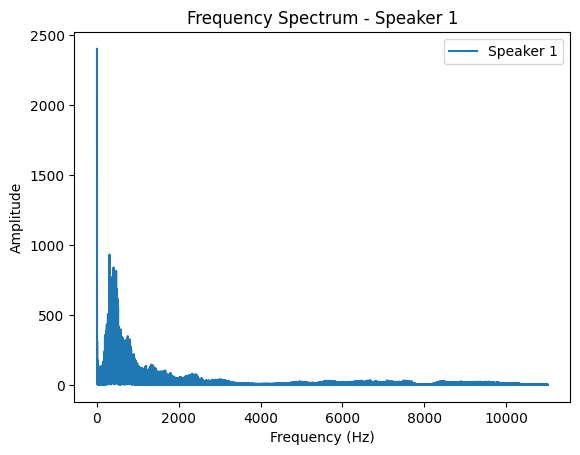

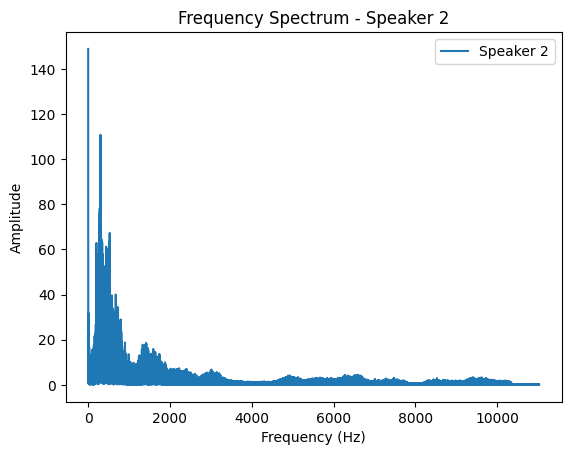

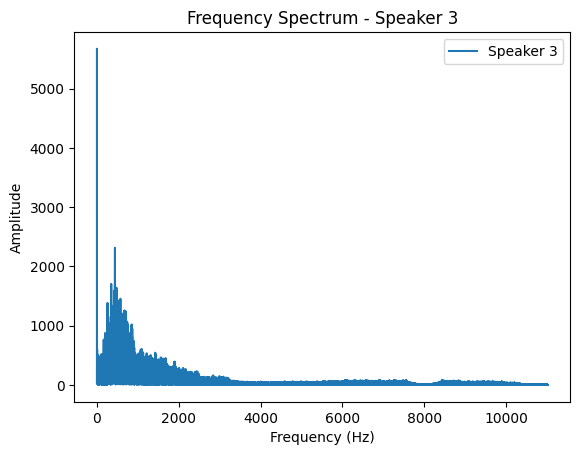

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_10.mp3
Bandpass Filter Applied with range: 20 Hz to 2969.237183988764 Hz for file call_10.mp3


C:\Users\aksha\anaconda3\envs\speechbrain\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


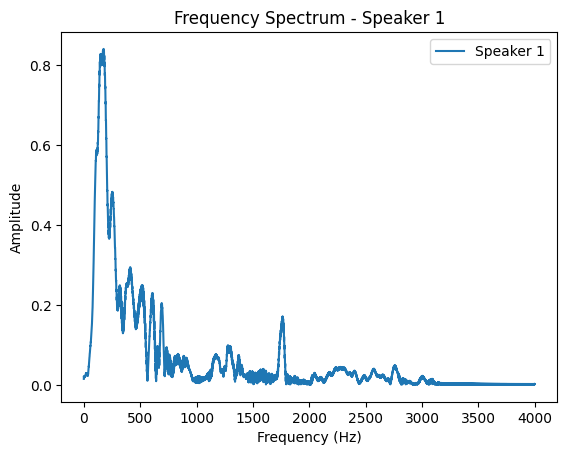

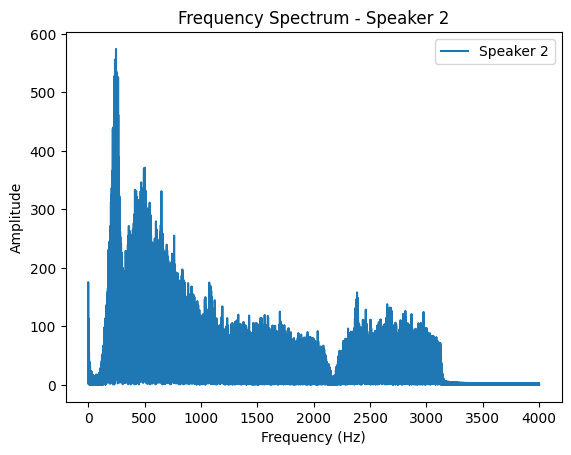

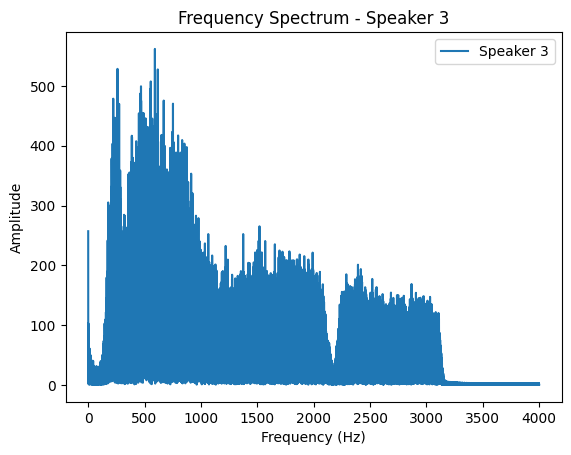

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_11.mp3
Bandpass Filter Applied with range: 119.60352422907488 Hz to 3169.9275803310616 Hz for file call_11.mp3


C:\Users\aksha\anaconda3\envs\speechbrain\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


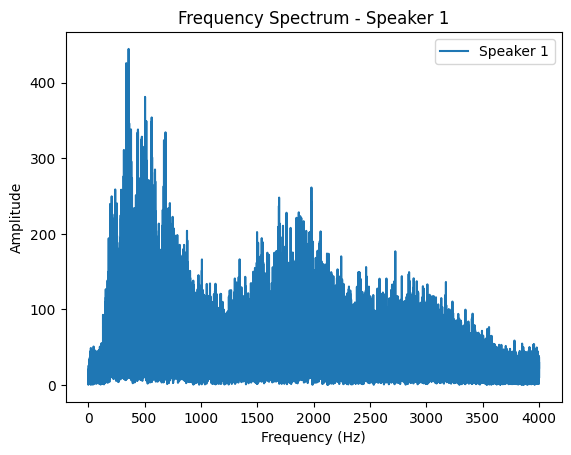

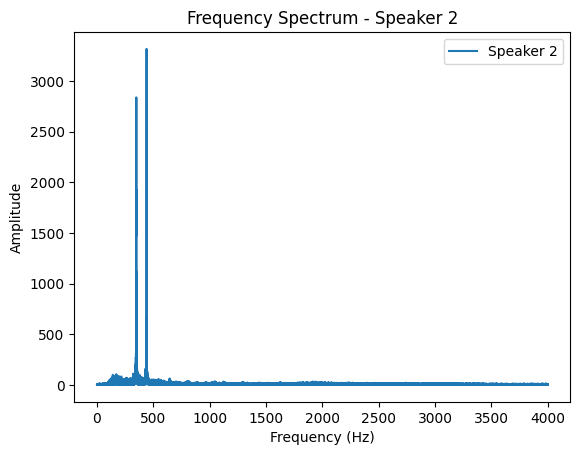

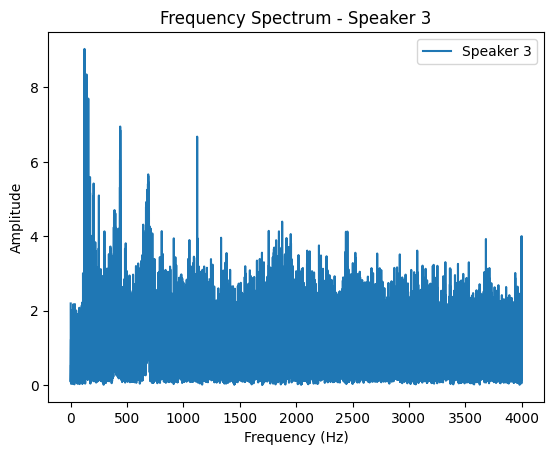

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_27.mp3
Bandpass Filter Applied with range: 72.29477611940297 Hz to 3063.188559322034 Hz for file call_27.mp3


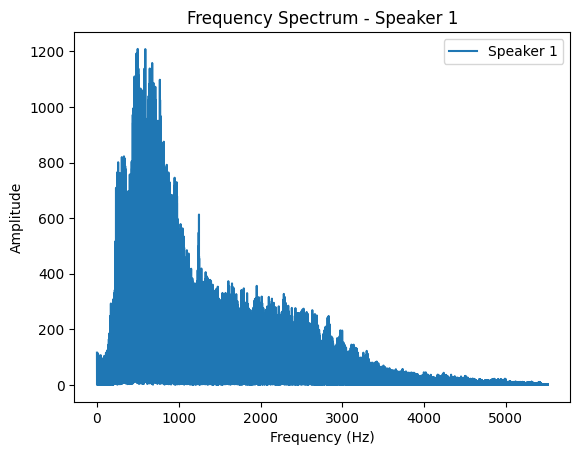

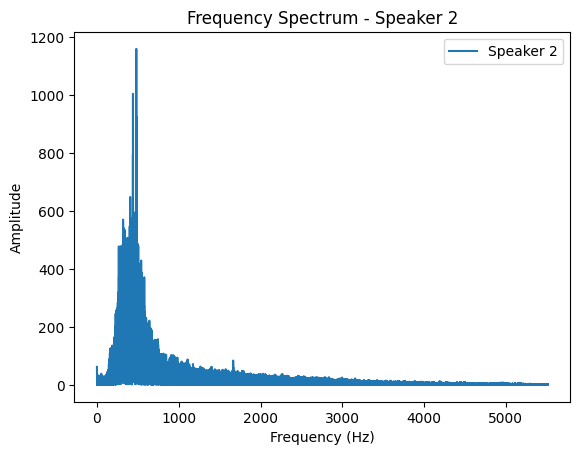

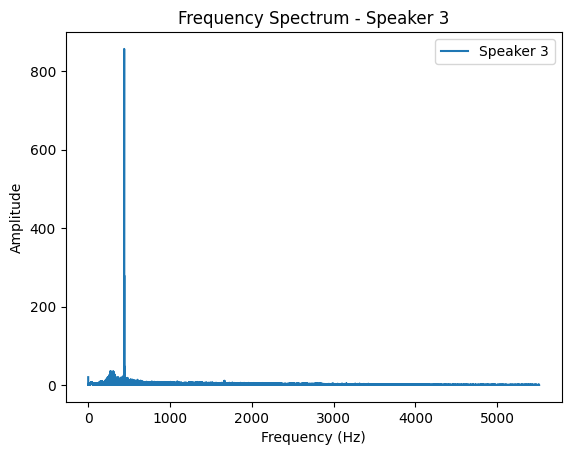

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_28.mp3
Bandpass Filter Applied with range: 389.83729808073474 Hz to 3175.3907277033877 Hz for file call_28.mp3


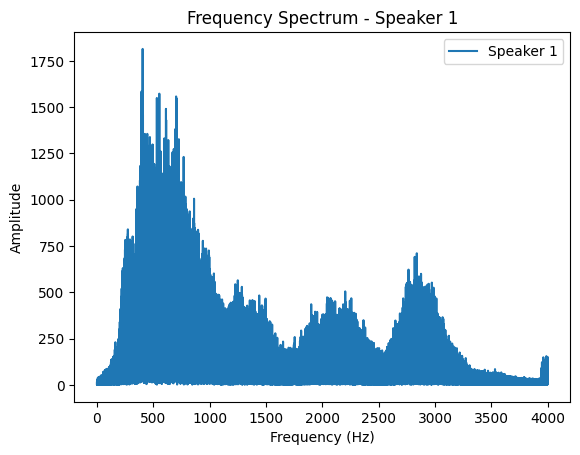

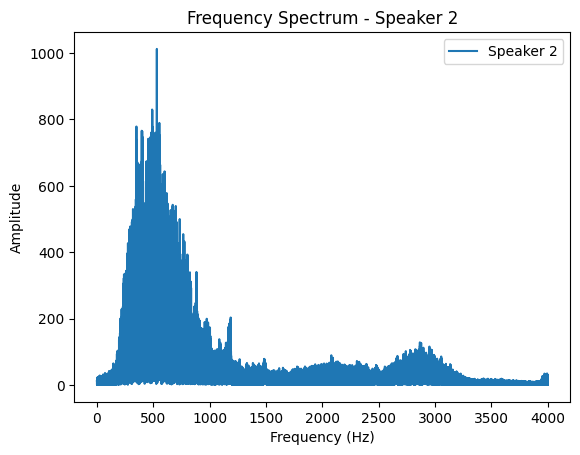

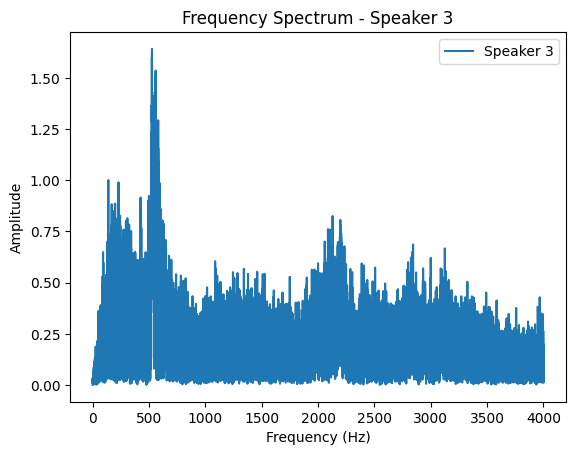

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_718.mp3
Bandpass Filter Applied with range: 300.18533772652387 Hz to 3205.3100263852243 Hz for file call_718.mp3


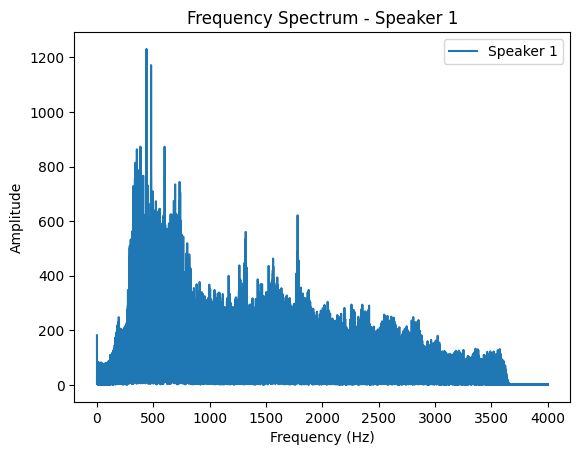

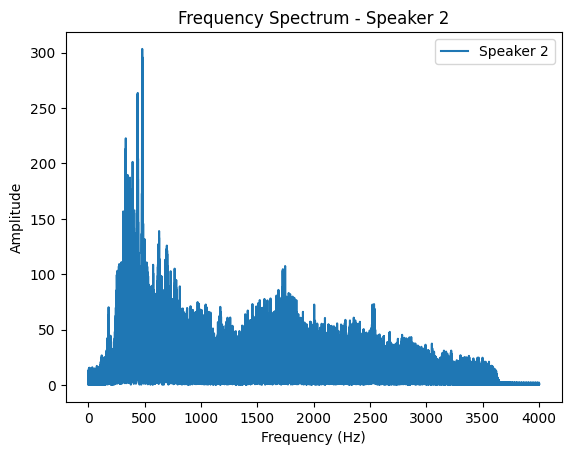

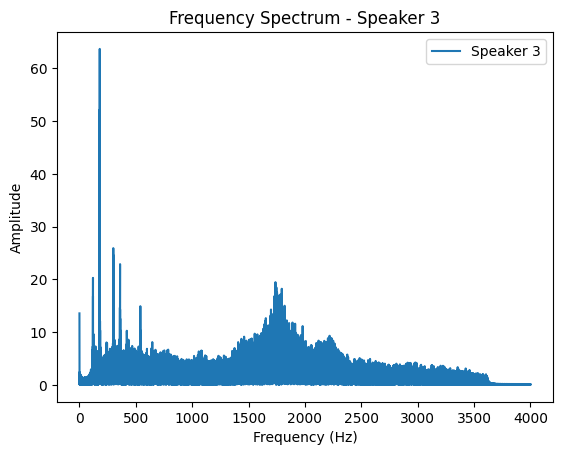

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_734.mp3
Bandpass Filter Applied with range: 129.62771045918367 Hz to 2980.658165599268 Hz for file call_734.mp3


C:\Users\aksha\anaconda3\envs\speechbrain\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


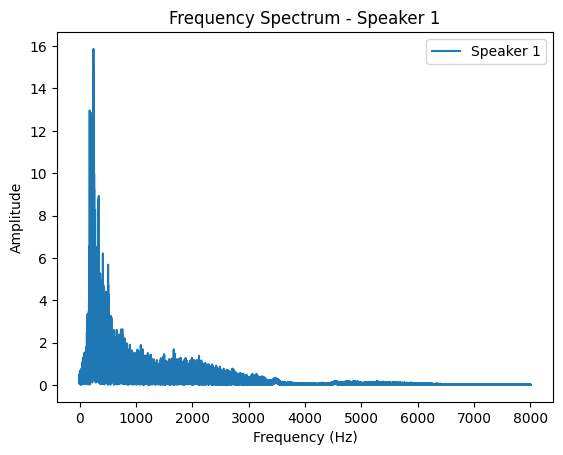

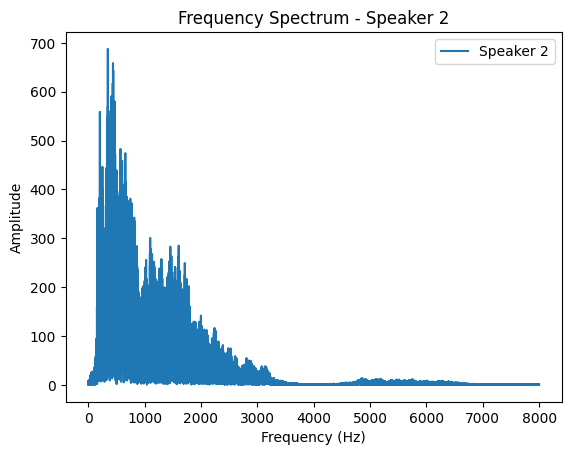

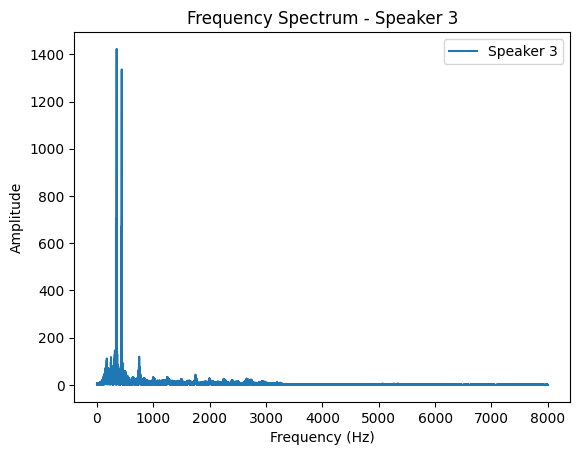

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_740.mp3
Bandpass Filter Applied with range: 129.8233114847535 Hz to 2969.602272727273 Hz for file call_740.mp3


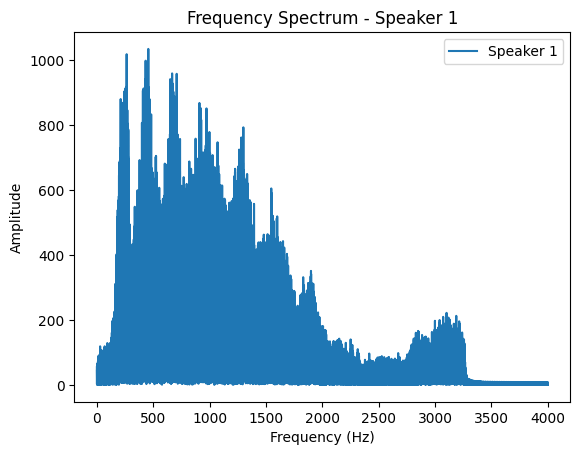

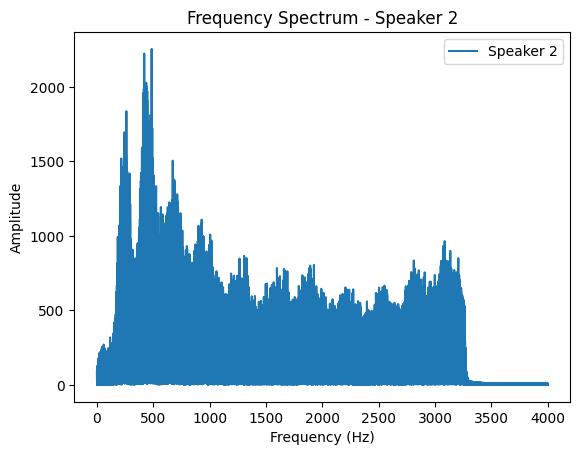

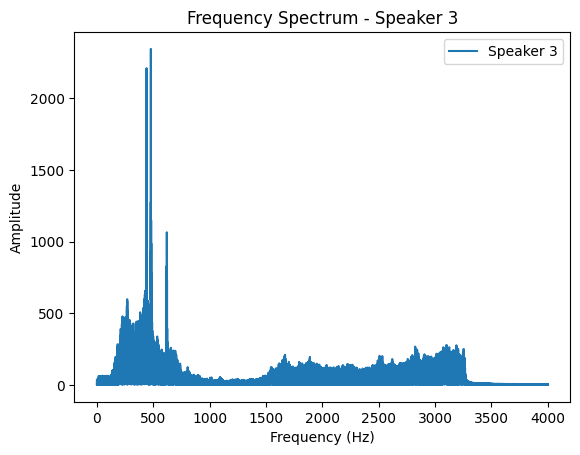

Processed and saved: C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\call_742.mp3
Bandpass Filter Applied with range: 213.52962427745666 Hz to 3207.2434971098264 Hz for file call_742.mp3


In [24]:
## Frequency based filtering on Multiple Audio files

import os
import librosa
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
import soundfile as sf

# Load audio and extract MFCC features
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def extract_features(audio, sr, hop_length=512):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=hop_length)
    return mfcc.T

# Perform speaker diarization using KMeans clustering
def speaker_diarization(mfcc_features, num_speakers=2):
    kmeans = KMeans(n_clusters=num_speakers, random_state=0)
    speaker_labels = kmeans.fit_predict(mfcc_features)
    return speaker_labels

# Identify the frequency range in an audio segment using FFT
def identify_frequency_range(audio_segment, sr):
    fft_vals = np.fft.rfft(audio_segment)
    freqs = np.fft.rfftfreq(len(audio_segment), 1 / sr)
    return freqs, np.abs(fft_vals)

# Bandpass filter function
def bandpass_filter(audio, sr, lowcut, highcut, order=5):
    sos = butter(order, [lowcut, highcut], btype='bandpass', fs=sr, output='sos')
    filtered_audio = sosfilt(sos, audio)
    return filtered_audio

# Main function for processing all audio files in a directory
def process_audio_files(input_dir, output_dir, num_speakers=2, hop_length=512):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Loop through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith(".wav") or filename.endswith(".mp3"):  # Process only audio files
            input_file = os.path.join(input_dir, filename)
            output_file = os.path.join(output_dir, filename)

            # Load and process each audio file
            audio, sr = load_audio(input_file)
            mfcc_features = extract_features(audio, sr, hop_length=hop_length)
            speaker_labels = speaker_diarization(mfcc_features, num_speakers=num_speakers)
            
            frame_size = hop_length
            num_frames = len(speaker_labels)
            speaker_frequencies = {}

            # Identify frequency ranges for each speaker
            for speaker in range(num_speakers):
                speaker_frames = [audio[i * frame_size: (i + 1) * frame_size]
                                  for i in range(num_frames) if speaker_labels[i] == speaker]
                speaker_segment = np.concatenate(speaker_frames) if speaker_frames else np.array([])

                if speaker_segment.size > 0:
                    freqs, fft_vals = identify_frequency_range(speaker_segment, sr)
                    dominant_freqs = freqs[np.argsort(fft_vals)[-10:]]
                    speaker_frequencies[speaker] = dominant_freqs
                    
                    plt.plot(freqs, fft_vals, label=f'Speaker {speaker + 1}')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Amplitude')
                    plt.title(f'Frequency Spectrum - Speaker {speaker + 1}')
                    plt.legend()
                    plt.show()
            
            # Compute dominant frequencies and apply the bandpass filter
            all_dominant_freqs = np.concatenate(list(speaker_frequencies.values()))
            max_freq = np.max(all_dominant_freqs)
            min_freq = np.min(all_dominant_freqs)

            a = max_freq + 2500
            b = max(20, min_freq - 50)  # Ensure 'b' is not less than 20 Hz

            # Apply bandpass filter
            filtered_audio = bandpass_filter(audio, sr, b, a)
            
            # Amplify filtered audio
            amplified_audio = filtered_audio * 3  # Amplify by 3X
            
            # Save the amplified filtered audio to the output file
            sf.write(output_file, amplified_audio, sr)

            print(f"Processed and saved: {output_file}")
            print(f"Bandpass Filter Applied with range: {b} Hz to {a} Hz for file {filename}")

# Define input and output directories
input_dir = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive\911_recordings\folder"
output_dir = r"C:\Users\aksha\Deep Learning Labs\MHA Project\Hindi_Audio_Datasets\archive"
num_speakers = 3

# Process all files in the input directory
process_audio_files(input_dir, output_dir, num_speakers=num_speakers)
